In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os, glob
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Final version
    * Encoder-Decoder model
    * Adam Optimizer: starting dynamic learning rate (ReduceLRonPlateau, starting rate = 0.01) and Early Stopping
    * Epochs = 50
    * Training accuracy = 84


In [2]:
os.getcwd()

'/kaggle/working'

In [3]:
traindata_dir = '/kaggle/input/global-wheat-detection/train'

In [4]:
os.path.exists(traindata_dir)

True

### Loading images

In [5]:
image_names = []
for file in os.listdir(traindata_dir):
    if file.endswith('.jpg'):
        image_names.append(file[:-4])

In [6]:
len(image_names)

3422

### Loading Boundary Boxes data¶

In [7]:
import matplotlib.pyplot as plt

In [8]:
bbox_df = pd.read_csv('../input/global-wheat-detection/train.csv', header=0)
bbox_df.head(5)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [9]:
groupby_df = bbox_df.groupby('image_id')

In [10]:
len(groupby_df)

3373

In [11]:
image_names = groupby_df.image_id.all().index.tolist()
image_names[:5]

['00333207f', '005b0d8bb', '006a994f7', '00764ad5d', '00b5fefed']

#### Splitting training data into train and test for model evaluation

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
randomseed=100
train_img_names, test_img_names = train_test_split(image_names, test_size = 0.2, random_state = randomseed)
train_img_names[:10], test_img_names[:10]

(['fa060c1f8',
  '347ecba39',
  '26373af4b',
  'ff86547fb',
  '69c5b6df3',
  'c2b7f1929',
  'e6af62317',
  '42e6efaaa',
  '92b234199',
  'f4bc4d24c'],
 ['250233aea',
  '7538c9a97',
  'fe287c574',
  '16d26f266',
  'a4b64deca',
  '1aa099fd7',
  '26871fd54',
  '7cb9748c4',
  '96bf13ac5',
  'b6b899073'])

#### Loading training data with resizing and no augmentation

In [14]:
import tensorflow as tf
from tensorflow import keras
tf.__version__

'2.2.0'

#### Resizing dimension

In [15]:
img_size = (256,256)

In [16]:
# Loading the images into an array
xtraindata_arr = np.zeros(shape = (len(train_img_names), img_size[0], img_size[1], 3), dtype = np.float32)
for i,fname in enumerate(train_img_names):
    tempimg = keras.preprocessing.image.load_img(os.path.join(traindata_dir, fname+'.jpg'), target_size=img_size)
    xtraindata_arr[i,:,:,:] = keras.preprocessing.image.img_to_array(tempimg)

In [17]:
xtraindata_arr.shape

(2698, 256, 256, 3)

In [18]:
np.max(xtraindata_arr[0]), np.min(xtraindata_arr[0])

(255.0, 0.0)

#### Scaling the pixel values to [0,1]

In [19]:
xtraindata_arr = xtraindata_arr/(img_size[1]-1)

#### Standardizing to $\mu$ = 0 and $\sigma$=1

In [20]:
x_mean = np.mean(xtraindata_arr)
x_std = np.std(xtraindata_arr)
xtrain_std = (xtraindata_arr - x_mean)/x_std
np.mean(xtrain_std), np.var(xtrain_std)

(5.449887e-06, 0.9999995)

In [21]:
np.min(xtrain_std), np.max(xtrain_std)

(-1.2112495, 3.0961275)

### Creating target images
    * Target images are of the same shape as the images but only 1 channel
    * The pixel values inside the boxes are of value 1.0 while outside are 0.0

In [22]:
from create_target_image_v3 import create_target_image

In [23]:
ytraindata_arr = np.zeros(shape = (len(train_img_names), img_size[0], img_size[1], 1), dtype = np.float32)
for i, fname in enumerate(train_img_names):
    ytraindata_arr[i,:,:,:] = create_target_image(fname, bbox_df, img_size[1])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [24]:
ytraindata_arr.shape, xtrain_std.shape

((2698, 256, 256, 1), (2698, 256, 256, 3))

In [25]:
np.max(ytraindata_arr), np.min(ytraindata_arr)

(1.0, 0.0)

### Model 1: simple custom Encoder-Decoder model using Keras Functional API

In [26]:
inputshape = xtrain_std.shape[1:]
inputshape

(256, 256, 3)

#### Encoder for downsampling

In [27]:
inputlayer = keras.layers.Input(shape=inputshape)

conv1 = keras.layers.Conv2D(32, (3,3), padding='same')(inputlayer)
batchnorm1 = keras.layers.BatchNormalization(axis=-1)(conv1)
act1 = keras.layers.Activation(tf.nn.relu)(batchnorm1)
mpool1 =  keras.layers.MaxPool2D(pool_size=(2,2))(act1)

conv2 = keras.layers.Conv2D(64, (3,3), padding='same')(mpool1)
batchnorm2 = keras.layers.BatchNormalization(axis=-1)(conv2)
act2 = keras.layers.Activation(tf.nn.relu)(batchnorm2)
mpool2 =  keras.layers.MaxPool2D(pool_size=(2,2))(act2)

conv3 = keras.layers.Conv2D(128, (3,3), padding='same')(mpool2)
batchnorm3 = keras.layers.BatchNormalization(axis=-1)(conv3)
act3 = keras.layers.Activation(tf.nn.relu)(batchnorm3)
mpool3 =  keras.layers.MaxPool2D(pool_size=(2,2))(act3)

conv4 = keras.layers.Conv2D(256, (3,3), padding='same')(mpool3)
batchnorm4 = keras.layers.BatchNormalization(axis=-1)(conv4)
act4 = keras.layers.Activation(tf.nn.relu)(batchnorm4)
mpool4 =  keras.layers.MaxPool2D(pool_size=(2,2))(act4)

#### Decoder for upsampling
    Will mirror the encoder

In [28]:
upsamp5 = keras.layers.UpSampling2D(size  = (2,2), interpolation='nearest')(mpool4)
convt5= keras.layers.Conv2DTranspose(filters=128, kernel_size=(1,1), strides=1)(upsamp5)
batchnorm5 = keras.layers.BatchNormalization(axis=-1)(convt5)
act5 = keras.layers.Activation(tf.nn.relu)(batchnorm5)

upsamp6 = keras.layers.UpSampling2D(size  = (2,2), interpolation='nearest')(act5)
convt6= keras.layers.Conv2DTranspose(filters=64, kernel_size=(1,1), strides=1)(upsamp6)
batchnorm6 = keras.layers.BatchNormalization(axis=-1)(convt6)
act6 = keras.layers.Activation(tf.nn.relu)(batchnorm6)

upsamp7 = keras.layers.UpSampling2D(size  = (2,2), interpolation='nearest')(act6)
convt7= keras.layers.Conv2DTranspose(filters=32, kernel_size=(1,1), strides=1)(upsamp7)
batchnorm7 = keras.layers.BatchNormalization(axis=-1)(convt7)
act7 = keras.layers.Activation(tf.nn.relu)(batchnorm7)

upsamp8 = keras.layers.UpSampling2D(size  = (2,2), interpolation='nearest')(act7)
outputlayer= keras.layers.Conv2DTranspose(filters=2, kernel_size=(1,1), strides=1)(upsamp8)

In [29]:
# keras.backend.clear_session()
# del model1

In [30]:
model1 = keras.Model(inputs = inputlayer, outputs=outputlayer)
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 64)      256   

#### Prediction and display

In [31]:
def model_prediction(model, img):
    pred_img = model(img)
    pred_img = tf.argmax(pred_img, axis=-1)
    pred_img = tf.squeeze(pred_img, axis=0)
    return pred_img

In [32]:
test_predimg = model_prediction(model1, xtrain_std[[0]])
test_predimg.shape

TensorShape([256, 256])

In [33]:
def display_pred(model, index=0):
    pred_img = model_prediction(model=model, img=xtrain_std[[index]])
    
    fig,ax = plt.subplots(1,3,figsize = (12,8))
    ax[0].matshow(xtrain_std[index])
    ax[1].matshow(np.squeeze(ytraindata_arr[index], axis=-1))
    ax[2].matshow(pred_img)
    
    plt.show()

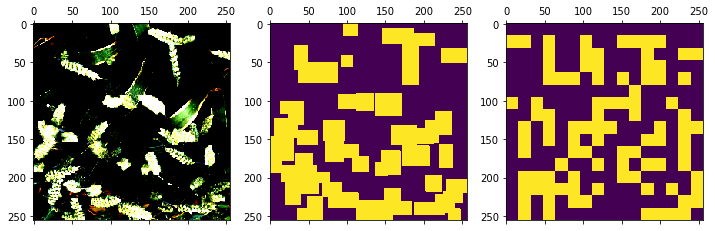

In [34]:
display_pred(model1)

#### Callbacks

In [35]:
os.getcwd()

'/kaggle/working'

##### Saving best model callback

In [36]:
saved_model = 'version6/model1'
if os.path.exists(saved_model):
    pass
else:
    os.makedirs(saved_model)

In [37]:
# import shutil
# shutil.rmtree(saved_model)

In [38]:
callbck_save = keras.callbacks.ModelCheckpoint(os.path.join(saved_model, 'model_{epoch}-{val_loss:0.3f}.h5'),monitor = 'val_loss',
                                           save_best_only = True, mode = 'min')

##### Display callback

In [39]:
from IPython.display import clear_output

In [40]:
class DisplayCallback(keras.callbacks.Callback):
    
    def __init__(self):
        super().__init__()
    
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        display_pred(model1)       
        print(model1.optimizer.lr)

##### Learning rate schedule

In [41]:
cb_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor=0.1, patience=5, min_lr=10**(-6))

##### *Early Stopping*

In [42]:
cb_es = keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10)

#### Compiling Model

In [43]:
model1.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.01), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

#### Training

In [44]:
batchsize = 64

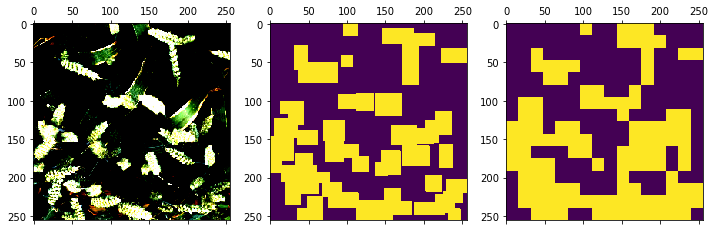

<tf.Variable 'Adam/learning_rate:0' shape=() dtype=float32, numpy=9.999999e-05>
34/34 [==============================] - 7s 211ms/step - loss: 0.3342 - accuracy: 0.8429 - val_loss: 0.3485 - val_accuracy: 0.8364 - lr: 1.0000e-04


In [45]:
epochs1=50
model1_his = model1.fit(x=xtrain_std, y=ytraindata_arr, batch_size=batchsize,epochs=epochs1,
                       validation_split=0.2,callbacks=[callbck_save, DisplayCallback(), cb_lr, cb_es], shuffle=True)

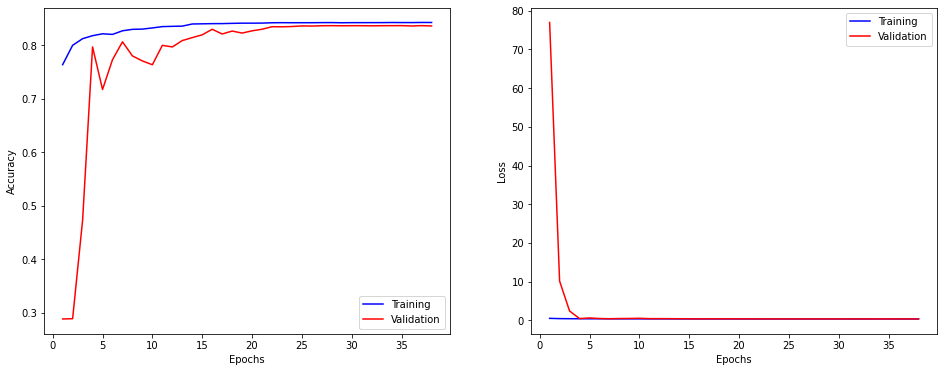

In [46]:
fig1, ax1 = plt.subplots(1,2, figsize = (16,6))
ax1[0].plot(np.arange(1, len(model1_his.epoch)+1), model1_his.history['accuracy'], 'b-', label = 'Training')
ax1[0].plot(np.arange(1, len(model1_his.epoch)+1), model1_his.history['val_accuracy'], 'r-', label = 'Validation')

ax1[1].plot(np.arange(1, len(model1_his.epoch)+1), model1_his.history['loss'], 'b-', label = 'Training')
ax1[1].plot(np.arange(1, len(model1_his.epoch)+1), model1_his.history['val_loss'], 'r-', label = 'Validation')

[ax1[i].legend(loc = 'best') for i in range(2)]
[ax1[i].set_xlabel('Epochs') for i in range(2)]

ax1[0].set_ylabel('Accuracy')
ax1[1].set_ylabel('Loss')

plt.show()

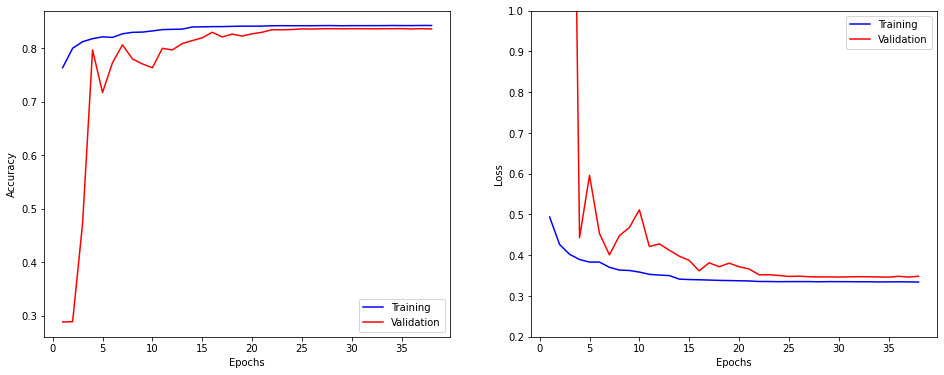

In [47]:
fig2, ax2 = plt.subplots(1,2, figsize = (16,6))
ax2[0].plot(np.arange(1, len(model1_his.epoch)+1), model1_his.history['accuracy'], 'b-', label = 'Training')
ax2[0].plot(np.arange(1, len(model1_his.epoch)+1), model1_his.history['val_accuracy'], 'r-', label = 'Validation')

ax2[1].plot(np.arange(1, len(model1_his.epoch)+1), model1_his.history['loss'], 'b-', label = 'Training')
ax2[1].plot(np.arange(1, len(model1_his.epoch)+1), model1_his.history['val_loss'], 'r-', label = 'Validation')

[ax2[i].legend(loc = 'best') for i in range(2)]
[ax2[i].set_xlabel('Epochs') for i in range(2)]

ax2[1].set_ylim([0.2,1])

ax2[0].set_ylabel('Accuracy')
ax2[1].set_ylabel('Loss')

plt.show()

#### Prediction

In [48]:
test_img_names[0]

'250233aea'

In [49]:
traindata_dir

'/kaggle/input/global-wheat-detection/train'

In [50]:
test_img = test_img_names[0]
test_img = keras.preprocessing.image.load_img(os.path.join(traindata_dir, test_img+'.jpg'))

In [51]:
test_img_to_arr = keras.preprocessing.image.img_to_array(test_img)
test_img_to_arr.shape

(1024, 1024, 3)

In [52]:
img_size

(256, 256)

In [53]:
def display_pred_testdata(model, image_dim, index):
    
    test_img = keras.preprocessing.image.load_img(os.path.join(traindata_dir, test_img_names[index]+'.jpg'), target_size=image_dim)
    
    test_img_to_arr = keras.preprocessing.image.img_to_array(test_img)
    test_img_to_arr = test_img_to_arr/(image_dim[1]-1) # normalizing
    test_img_to_arr = (test_img_to_arr - x_mean)/x_std # standardizing 
    
    test_img_y = create_target_image(test_img_names[index], bbox_df, image_dim[0])
        
    pred_img = model_prediction(model=model, img=np.expand_dims(test_img_to_arr, axis=0))
    
    fig,ax = plt.subplots(1,3,figsize = (12,8))
    ax[0].matshow(test_img_to_arr)
    ax[0].set_title('Wheat image')
    ax[1].matshow(np.squeeze(test_img_y, axis=-1))
    ax[1].set_title('Y image')
    ax[2].matshow(pred_img)
    ax[2].set_title('Predicted image')
    
    plt.show()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


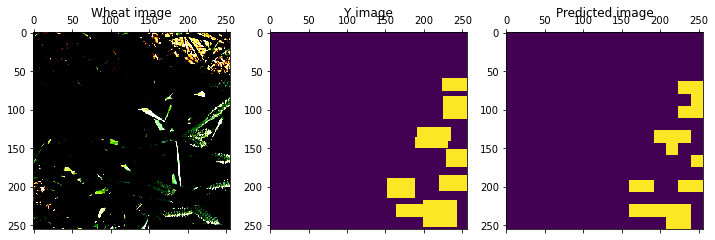

In [54]:
display_pred_testdata(model1, img_size, 0)

    * Validation accuracy similar to training accuracy implying very little overfitting.

## Test image accuracies (split from training data) and display

In [55]:
best_model = keras.models.load_model(os.path.join(saved_model, 'model_35-0.346.h5'))

In [56]:
best_model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001), loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [57]:
len(test_img_names)

675

In [58]:
# 1. Loading the test images into an array
# 2. Normalizing
# 3. Standardizing
xtestdata_arr = np.zeros(shape = (len(test_img_names), img_size[0], img_size[1], 3), dtype = np.float32)
for i,fname in enumerate(test_img_names):
    tempimg = keras.preprocessing.image.load_img(os.path.join(traindata_dir, fname+'.jpg'), target_size=img_size)
    xtestdata_arr[i,:,:,:] = keras.preprocessing.image.img_to_array(tempimg)
    
# Normalizing
xtestdata_arr = xtestdata_arr/(img_size[1]-1)

# Standardizing
xtestdata_std = (xtestdata_arr-x_mean)/x_std

In [59]:
np.min(xtestdata_std), np.max(xtestdata_std)

(-1.2112495, 3.0961275)

In [60]:
ytestdata_arr = np.zeros(shape = (len(test_img_names), img_size[0], img_size[1], 1), dtype = np.float32)
for i, fname in enumerate(test_img_names):
    ytestdata_arr[i,:,:,:] = create_target_image(fname, bbox_df, img_size[1])

In [61]:
np.min(ytestdata_arr), np.max(ytestdata_arr)

(0.0, 1.0)

#### Test Accuracy

In [62]:
best_model.evaluate(xtestdata_std, ytestdata_arr, batch_size=batchsize)

11/11 [==============================] - 1s 88ms/step - loss: 0.3387 - accuracy: 0.8425


[0.3386756181716919, 0.8425220847129822]

    * 84.26% test data accuracy

#### Training on the complete dataset

In [63]:
import gc

In [64]:
gc.collect()

15204

In [65]:
epochs2 = 100
initial_epoch = model1_his.epoch[-1]
initial_epoch

37

In [66]:
model1_his2 = best_model.fit(x=xtrain_std, y=ytraindata_arr, batch_size=batchsize,epochs=epochs2,initial_epoch=initial_epoch,
                       validation_split=0.0, shuffle=True)

Epoch 38/100
43/43 [==============================] - 8s 179ms/step - loss: 0.3417 - accuracy: 0.8398
Epoch 39/100
43/43 [==============================] - 8s 177ms/step - loss: 0.3390 - accuracy: 0.8409
Epoch 40/100
43/43 [==============================] - 7s 174ms/step - loss: 0.3381 - accuracy: 0.8410
Epoch 41/100
43/43 [==============================] - 8s 176ms/step - loss: 0.3369 - accuracy: 0.8416
Epoch 42/100
43/43 [==============================] - 7s 173ms/step - loss: 0.3366 - accuracy: 0.8417
Epoch 43/100
43/43 [==============================] - 8s 176ms/step - loss: 0.3351 - accuracy: 0.8424
Epoch 44/100
43/43 [==============================] - 8s 175ms/step - loss: 0.3353 - accuracy: 0.8424
Epoch 45/100
43/43 [==============================] - 7s 174ms/step - loss: 0.3346 - accuracy: 0.8426
Epoch 46/100
43/43 [==============================] - 7s 173ms/step - loss: 0.3327 - accuracy: 0.8434
Epoch 47/100
43/43 [==============================] - 8s 181ms/step - loss: 0.3327

In [73]:
best_model.save(os.path.join(saved_model, 'model_%d-acc_%0.4f.h5'%(epochs2,model1_his2.history['accuracy'][-1])))

### Display

In [74]:
import random

In [75]:
import bbox_coordinates as bc

In [76]:
img = random.choice(range(len(test_img_names)))
img

180

In [77]:
pred_img = model_prediction(best_model, xtestdata_std[[img]])
pred_img.shape

TensorShape([256, 256])

In [78]:
# bbox coordinates
scanned_list = bc.return_edge_val_along_rows(pred_img.numpy())
bbox_arr = bc.edge_coordinates(scanned_list)

##### Predicted Image

In [79]:
display_pred_img = bc.draw_img_with_bbox(xtestdata_arr[img], bbox_arr)

In [192]:
# import importlib, sys
# importlib.reload(sys.modules['bbox_coordinates'])

##### Original Image

In [80]:
from image_bboxes import bboxes_of_image, aggregation_func

In [81]:
test_img_names[img]

'bfe0b9132'

In [82]:
test_bbox_values = bboxes_of_image(test_img_names[img], bbox_df)
test_bbox_values = aggregation_func(test_bbox_values)
# bbox values of test image

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [83]:
# loading the original test image
test_img = keras.preprocessing.image.load_img(os.path.join(traindata_dir,test_img_names[img]+'.jpg'))
test_img_arr = keras.preprocessing.image.img_to_array(test_img)
img_arr_shape = test_img_arr.shape
true_bbox_img = tf.image.draw_bounding_boxes(test_img_arr.reshape(1,img_arr_shape[0], img_arr_shape[1],
                                                                 img_arr_shape[2]),
                                   boxes=tf.reshape(tf.convert_to_tensor(test_bbox_values/img_arr_shape[0]),
                                                 shape = (1,-1,4)), colors = np.array([[1.0,0.0,1.0]]))/255 
# dividing by 255, else image is not shown clearly in the notebook, shows fine when run as a script

##### True and Predicted

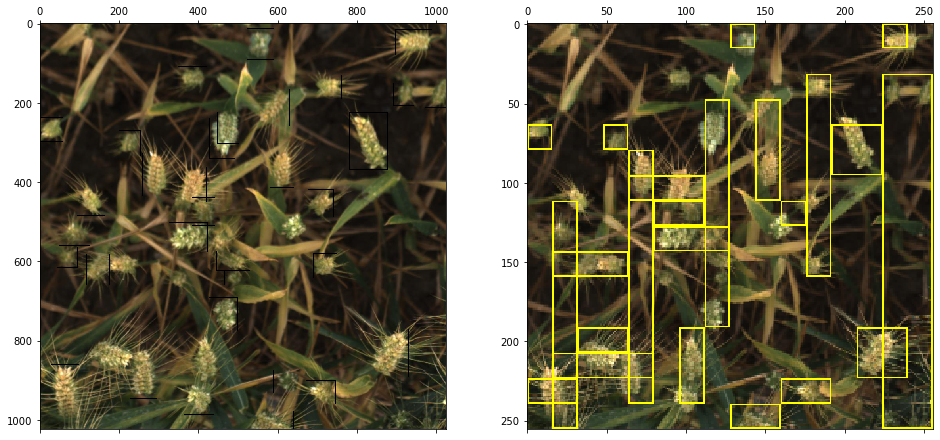

In [84]:
fig, ax = plt.subplots(1, 2, figsize = (16,16))

ax[0].matshow(np.squeeze(true_bbox_img.numpy(),0))
ax[1].matshow(display_pred_img)

plt.show()

## Test data accuracy (from the provided test images) and display

In [85]:
testdata_dir = '/kaggle/input/global-wheat-detection/test'

In [86]:
test_bbox_df = pd.read_csv('../input/global-wheat-detection/sample_submission.csv', header=0)
test_bbox_df

,image_id,PredictionString
0,aac893a91,1.0 0 0 50 50
1,51f1be19e,1.0 0 0 50 50
2,f5a1f0358,1.0 0 0 50 50
3,796707dd7,1.0 0 0 50 50
4,51b3e36ab,1.0 0 0 50 50
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


In [87]:
testdata_img = test_bbox_df.image_id
testdata_img

0    aac893a91
1    51f1be19e
2    f5a1f0358
3    796707dd7
4    51b3e36ab
5    348a992bb
6    cc3532ff6
7    2fd875eaa
8    cb8d261a3
9    53f253011
Name: image_id, dtype: object

In [88]:
# 1. Loading the test images into an array
# 2. Normalizing
# 3. Standardizing
xtest_arr = np.zeros(shape = (len(testdata_img), img_size[0], img_size[1], 3), dtype = np.float32)
for i,fname in enumerate(testdata_img):
    print(fname)
    tempimg = keras.preprocessing.image.load_img(os.path.join(testdata_dir, fname+'.jpg'), target_size=img_size)
    xtest_arr[i,:,:,:] = keras.preprocessing.image.img_to_array(tempimg)
    
# Normalizing
xtest_arr = xtest_arr/(img_size[1]-1)

# Standardizing
xtest_std = (xtest_arr-x_mean)/x_std

aac893a91
51f1be19e
f5a1f0358
796707dd7
51b3e36ab
348a992bb
cc3532ff6
2fd875eaa
cb8d261a3
53f253011


In [89]:
np.min(xtest_std), np.max(xtest_std)

(-1.2112495, 3.0961275)

In [90]:
len(testdata_img)

10

#### Test Data Prediction

In [91]:
def rearranging_func(arr = np.array([])):
    
    """
    from [ymin, xmin, ymax, xmax] to [xmin, ymin, width, height]
    """
    
    width = arr[:, 3] - arr[:,1] 
    height = arr[:,2] - arr[:,0] 
    
    return np.vstack([arr[:,1], arr[:,0], width, height]).T

In [92]:
from skimage.transform import resize

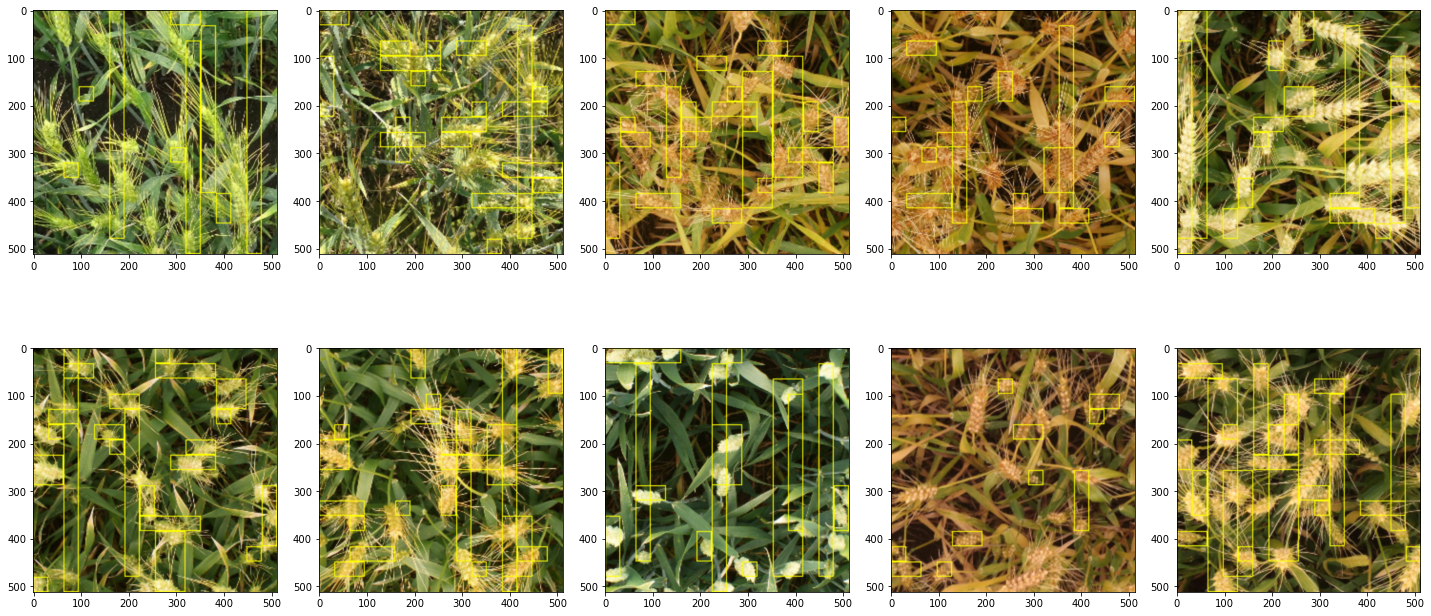

In [93]:
test_fig, test_ax = plt.subplots(2,5, figsize = (20,10))
test_ax = test_ax.flatten()

predicted_df = pd.DataFrame(columns = ['image_id', 'PredictionString'])
for i in range(10):
    pred_img = model_prediction(best_model, xtest_std[[i]])
    scanned_list = bc.return_edge_val_along_rows(pred_img.numpy())
    bbox_arr = bc.edge_coordinates(scanned_list)
    upscaling = bbox_arr*4
    # since the original image is of size 1024*1024 while the predicted is of size 256*256
    rearranged_values = rearranging_func(upscaling)
    # rearranging as per the required format
    
    label_names = [testdata_img[i]]*bbox_arr.shape[0]
    temp_df = pd.DataFrame(data=zip(label_names,rearranged_values), columns = ['image_id', 'PredictionString'])
    predicted_df = pd.concat([predicted_df, temp_df])
    
    resize_image = resize(bc.draw_img_with_bbox(xtest_arr[i], bbox_arr), output_shape=(512,512))
    test_ax[i].imshow(resize_image)


plt.tight_layout()    
plt.show()   


In [94]:
predicted_df

,image_id,PredictionString
0,aac893a91,"[320, 0, 60, 956]"
1,aac893a91,"[576, 0, 124, 60]"
2,aac893a91,"[896, 0, 60, 1020]"
3,aac893a91,"[704, 64, 60, 700]"
4,aac893a91,"[640, 128, 60, 892]"
...,...,...
15,53f253011,"[576, 640, 60, 60]"
16,53f253011,"[768, 640, 188, 60]"
17,53f253011,"[0, 768, 124, 60]"
18,53f253011,"[256, 832, 60, 60]"


In [97]:
predicted_df.to_csv('submission.csv')